# Part 1: Spam or ham? (45 marks)

In the spam literature, an email that is **not** spam is called _ham_. 

Your task is to develop a Naive Bayes classifier to determine whether a given email is spam or ham.

## The data: Spam!

The following cell loads your training data set (called _training set_).

In [307]:
import numpy as np

training_spam = np.loadtxt(open("data/training_spam.csv"), delimiter=",")
print("Shape of the spam training data set:", training_spam.shape)

Shape of the spam training data set: (1000, 55)


Your training set consists of 1000 rows and 55 columns. Each row corresponds to one email message. The first column is the _response_ variable and describes whether a message is spam (1) or ham (0). The remaining 54 columns are _features_ that you will use to build a classifier. These features correspond to 54 different keywords (such as "money", "free", and "receive") and special characters (such as ":", "!", and "$"). A feature has the value "1" if the keyword appears in the message and "0" otherwise.

## The model:  Naïve Bayes
Your [naïve Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier will distinguish between two classes:

* **$C = 1$ for spam messages **
* **$C = 0$ for ham messages. **


The classifier builds a model for the probability $P(C=c\ |\ message)$ that a given message belongs to a certain class. A new message is then classified based on the Bayesian *maximum a posteriori* estimate

\begin{equation}
\hat{c} = \underset{c \in \{0,1\}}{argmax} \  P(C=c\ |\ message).
\end{equation}

Using Bayes' rule we can write

\begin{equation}
P(C=c\ |\ message) = \frac{P(message\ |\ C=c)P(C=c)}{P(message\ |\ C=1)P(C=1) + P(message\ |\ C=0)P(C=0)}.  \quad \quad 
\end{equation}

The denominator is the same for both classes and we can thus drop it to get

\begin{equation}
P(C=c\ |\ message) \propto P(message\ |\ C=c)P(C=c).
\end{equation}


We represent a message using a binary [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model. Specifically, a message is represented as $\mathbf{w} = (w_1, ..., w_k)$, where $w_i = 1$ if the word $w_i$ appears in the message and $w_i = 0$ otherwise. We assume **class-conditional independence between occurences of known words** and can therefore write 

\begin{equation}
P(message\ |\ C=c) = \prod_{i = 1}^k P(w_i\ |\ C=c).
\end{equation}

The classifier now can be written as follows :

\begin{equation}
\hat{c} = \underset{c \in \{0,1\}}{argmax} \ [ P(C=c)   \prod_{i = 1}^k P(w_i\ |\ C=c) ].
\end{equation}


### Multinomial Naïve Bayes

Different naïve Bayes models differ in their distributional assumptions of $P(w\ |\ C=c)$, that is, the conditional likelihood of a word $w$ given a class $c$. We will model $P(w\ |\ C=c)$ using a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution). Intuitively, the multinomial distribution assumes that the words of a message are "drawn" independently from a bag of $k$ different keywords. Depending on the class membership $c$, each keyword has a probability $\theta_{class, word}$ of being drawn. For example,

* $\theta_{spam, w}$ will have high value for $w \in \{$bank, transfer, buy, viagra... $\}$.
* $\theta_{ham, w}$ will have high value for $w \in \{$paper, conference, proposal, experiment... $\}$, if the training data was mostly gathered from emails of researchers.

Both the class priors $P(C=c)$ and the class-conditional likelihoods $\theta_{c, w} = P(w\ |\ C=c)$ have to be estimated from the training data. The 
$\theta_{c, w}$ are estimated by counting the relative frequencies in the training data. Use **Laplace-smoothing** with $\alpha = 1$, that is,

\begin{equation}
\theta_{c, w} = \frac{n_{c, w} + \alpha}{n_{c} + k \alpha},
\end{equation}

where $n_{c, w}$ is the number of times the word $w$ appears in messages of class $c$ in the training set, $n_{c}$ is the total count of words for all messages of class $c$, and $k$ is the number of features (key-words).

The likelihood of observing $\mathbf{w}$ in a message of class $c$ is proportional to
\begin{equation}
P(\mathbf{w}\ |\ C=c) \propto \prod_{i = 1}^k  (\theta_{c, i})^{w_i}.
\end{equation}

### Increasing numerical stability
We can increase the numerical stability of the algorithm by taking logarithms of the posterior distributions, that is,
\begin{equation}
\hat{c} = \underset{c \in \{0,1\}}{argmax} \ log( P(C=c)   \prod_{i = 1}^k P(w_i\ |\ C=c) ) \\
 = \underset{c \in \{0,1\}}{argmax} \ [ log( P(C=c)) + \sum_{i = 1}^k w_i \ log(\theta_{c, i}) ].
\end{equation}

You will implement this more stable version of the algorithm in developing your classifier. 

## Part 1A: Estimate class priors (10 marks)

Define a function called `estimate_log_class_priors()` that takes as input a data set with binary response variable (0s and 1s) in the left-most column and returns a numpy array containing the **the logarithm** of the empirical class priors $P(C=c)$ for $c \in \{0, 1\}$.

In [315]:
import numpy as np
def estimate_log_class_priors(data):
    """
    Given a data set with binary response variable (0s and 1s) in the
    left-most column, calculate the logarithm of the empirical class priors,
    that is, the logarithm of the proportions of 0s and 1s:
    log(P(C=0)) and log(P(C=1))

    :param data: a two-dimensional numpy-array with shape = [n_samples, 1 + n_features]
                 the first column contains the binary response (coded as 0s and 1s).

    :return log_class_priors: a numpy array of length two
    """
    num = len(data[:,1]) # number of samples

    log_class_priors = np.zeros(2) 
    count = 0
    for i in range(num):  #iterate over  samples
        if data[i,0]==1: 
            count+=1 #if the sample is in class 1 increment
    log_class_priors[0] = np.log((num-count)/num)
    log_class_priors[1] = np.log(count/num)

    return log_class_priors
priors = estimate_log_class_priors(training_spam)


In [316]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.
log_class_priors = estimate_log_class_priors(training_spam)
print("result", log_class_priors)

# Check length
assert(len(log_class_priors) == 2)

# Check whether the returned object is a numpy.ndarray
assert(isinstance(log_class_priors, np.ndarray))

# Check wehther the values of this numpy.array are floats.
assert(log_class_priors.dtype == float)


result [-0.48939034 -0.94933059]


## Part 1B: Estimate class-conditional likelihoods (10 marks)
Define a function called `estimate_log_class_conditional_likelihoods()` that takes as input a data set with binary response variable (0s and 1s) in the left-most column and returns **the logarithm** of the empirical class-conditional likelihoods $log(P(w_i | c_j))$ for all words $w_i$ and both classes ($j \in {0, 1}$). These parameters should be returned in a two-dimensional numpy-array with shape = `[num_classes, num_features]`.

Assume a multinomial feature distribution and use Laplace smoothing with $\alpha = 1$... basically add alpha to the numerator and number of classes to the denominator

Hint: many `numpy`-functions contain an `axis` argument. If you specify `axis=0`, you can perform column-wise (that is, feature-wise!) computations.

In [317]:
def estimate_log_class_conditional_likelihoods(data, alpha=1.0):
    """
    Given a data set with binary response variable (0s and 1s) in the
    left-most column and binary features, calculate the empirical
    class-conditional likelihoods, that is,
    log(P(w_i  c_j)) for all features i and both classes (j in {0, 1}).

    Assume a multinomial feature distribution and use Laplace smoothing
    of alpha > 0.

    :param data: a two-dimensional numpy-array with shape = [n_samples, n_features]

    :return theta:
        a numpy array of shape = [2, n_features]. theta[j, i] corresponds to the
        logarithm of the probability of feature i appearing in a sample belonging 
        to class j.
    """
 
    (num_s, num_f) = np.shape(data)
    num_f +=-1    
    c0 = data[data[:,0] == 0,1:] #take all the samples in class1
    
    c1 = data[data[:,0] == 1,1:] #take all the classes in class0

    cond1 = np.sum(c1, axis =0) + alpha  #summ the number of features in each sample for samples in class 1
    
    cond0 = np.sum(c0, axis = 0) + alpha
    n0 = np.sum(cond0) + (alpha*num_f) 
    n1 = np.sum(cond1) + (alpha*num_f)
    theta = np.zeros((2,num_f))

    theta[0,:] = np.log(cond0/n0)
    theta[1,:] = np.log(cond1/n1)
    #print(np.shape(c1),np.shape(c0),np.shape(cond1),np.shape(cond0), (n0), (n1))

    return theta
conditionals = estimate_log_class_conditional_likelihoods(training_spam, alpha=1.0)

#print(conditionals)

In [318]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.
log_class_conditional_likelihoods = estimate_log_class_conditional_likelihoods(training_spam, alpha=1.0)

# Check data type(s)
assert(isinstance(log_class_conditional_likelihoods, np.ndarray))

# Check shape of numpy array
assert(log_class_conditional_likelihoods.shape == (2, 54))

# Check data type of array elements
assert(log_class_conditional_likelihoods.dtype == float)


## Part  1C: Classify e-mails (10 marks)

Having calculated the log class priors and the log class-conditional likelihoods for a given training set, define a function called `predict()`that takes a data set of new messages as input and predicts for each message whether it is spam or not. Note that the input should **not** contain a response variable.

Use your `predict()` function to classify the messages of your **training data set** `training_spam`. Compute the accuracy of your algorithm _in the training set_ by comparing your predictions to the true class values. Accuracy is simply defined as the proportion of true predictions made by your classifier. Store the accuracy of your naïve Bayes algorithm in a variable called `training_set_accuracy`.

In [327]:
def predict(new_data, log_class_priors, log_class_conditional_likelihoods):
    """
    Given a new data set with binary features, predict the corresponding
    response for each instance (row) of the new_data set.

    :param new_data: a two-dimensional numpy-array with shape = [n_test_samples, n_features].
    :param log_class_priors: [P(C=0), P(C=1)]
    :param log_class_conditional_likelihoods: a numpy array of shape = [2, n_features].
        theta[j, i] corresponds to the logarithm of the probability of feature i appearing
        in a sample belonging to class j.
    :return class_predictions: a numpy array containing the class predictions for each row
        of new_data.
    """
    # iterate over samples 
    # get a 1xnum_samples array of sums of activated log class conditionals.
        # 
    # add this to the priors
    
    (n_test_samples, n_features) = np.shape(new_data)

    class_predictions = np.full(n_test_samples, 2)
    tmp1 = log_class_priors[1] # work out P(C=1)
    tmp0 = log_class_priors[0] # P(C=0)

    
#    print(log_class_conditional_likelihoods)

    for i in range(n_test_samples): # iterate through number of samples
        k1 = np.multiply(new_data[i,:],log_class_conditional_likelihoods[1,:])
        k0 = np.multiply(new_data[i,:],log_class_conditional_likelihoods[0,:])
        #print(k1)
        #print(k2)
        count1 = np.sum(k1,0) # sum over the log conditional probabilities of active feat
        count0 = np.sum(k0,0) # sum over log conditional probabilities of active feat
        
        #check which one is bigger
        if tmp1+count1 > tmp0+count0:
            class_predictions[i] = 1
        else:
            class_predictions[i] = 0
            
    return class_predictions

def accuracy(y_predictions, y_true):
    """
    Calculate the accuracy.
    
    :param y_predictions: a one-dimensional numpy array of predicted classes (0s and 1s).
    :param y_true: a one-dimensional numpy array of true classes (0s and 1s).
    
    :return acc: a float between 0 and 1 
    """
    ### YOUR CODE HERE...
    count = 0
    num = len(y_predictions)
    for i in range(num):
        if y_predictions[i] == y_true[i]:
            count+=1
        
    return count/num
class_predictions = predict(training_spam[:,1:],priors, conditionals)

training_set_accuracy = accuracy(class_predictions,training_spam[:,0])
print(training_set_accuracy)

0.892


In [320]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.
class_predictions = predict(training_spam[:, 1:], log_class_priors, log_class_conditional_likelihoods)

# Check data type(s)
assert(isinstance(class_predictions, np.ndarray))

# Check shape of numpy array
assert(class_predictions.shape == (1000,))

# Check data type of array elements
assert(np.all(np.logical_or(class_predictions == 0, class_predictions == 1)))
       
# Check accuracy function
true_classes = training_spam[:, 0]
training_set_accuracy = accuracy(class_predictions, true_classes)
assert(isinstance(training_set_accuracy, float))
assert(0 <= training_set_accuracy <= 1)


## Part 1D: Classifying previously unseen data (10 marks).
The following cell loads a new set of 500 messages.

In [292]:
testing_spam = np.loadtxt(open("data/testing_spam.csv"), delimiter=",")
print("Shape of the testing spam data set:", testing_spam.shape)
#testing_spam

Shape of the testing spam data set: (500, 55)


Use the naïve Bayes algorithm that you trained on `training_spam` in order to classify all messages in the `testing_spam` data set. Store the resulting accuracy in a variable called `testing_set_accuracy`.

In [329]:
b= estimate_log_class_priors(training_spam)
c= estimate_log_class_conditional_likelihoods(training_spam,1)
testing_set_accuracy = accuracy(predict(testing_spam[:,1:], b, c),testing_spam[:,0])
print(testing_set_accuracy)


0.838


In [326]:
# This is a test cell. Do not delete or change.

## Part 1E: Discussion (5 marks).


In 3 sentences or less: Compare the accuracy of your classifier on the training set and on the test set. Are they different? If yes, how do you explain the difference?

YOUR ANSWER HERE:  <span style="color:red"> The accuracy on the training set is higher, by 5.4% which isn't that much, than that of on the test set because I trained my classifier on the training set and so, I may have probably slightly overfit my model to the training set because of how small my data set is. However, Naive Bayes is really really simple so it is more likely just due to randomness. </span >



# Part 2: Zero or One? (55 marks)

In this part of the coursework, you will develop a classifier for a different problem. All you will be given about this problem is a training data set. Your objective is to develop a classifier that will have the highest accuracy in unseen examples.

The following cell loads the training data set.

In [330]:
import numpy as np

training_data = np.loadtxt(open("data/training_data_part_2.csv"), delimiter=",")
print("Shape of the training data set:", training_data.shape)


Shape of the training data set: (5000, 39)


The first column is again the response variable. The remaining 38 columns are binary features. You have multiple tasks:

(1) Your first task is to write a function called `train()` that takes `training_data` as input and returns all the fitted parameters of your model. Note that the fitted parameters of your model depend on the model you choose. For example, if you use a naïve Bayes classifier, you could return a list of class priors and conditional likelihoods. (This function will allow us to compute your model on the fly. We should be able to execute it in less than 10 minutes.) 

(2) Your second task is to provide a variable called `fitted_model` which stores the model parameters you found by executing your train() function on the training_data. If your train function takes more than 20 seconds to run, this variable should load precomputed parameter values (possibly from a file) rather than execute the train() function. 

In [334]:
import numpy as np 
from sklearn.linear_model import LogisticRegression
import math

#work out euclidean distance between two data instances
def euclid(neighbour, test):
    euc = math.sqrt(np.dot(neighbour,neighbour) + np.dot(test,test) - 2*np.dot(neighbour,test))
    return euc
#input training without 
def neighbours(training, test, k):
    
    [a,b] = np.shape(training)
    distances = np.zeros(a)
    for i in range(a):
        distances[i] = euclid(test,training[i])
    indices = np.argpartition(distances, k)[:k]
    return indices
    
def vote(training, neighbours):
    v = np.mean(training[neighbours],0)[0]
    if v >0.5:
        return 1
    return 0
    
    
def data_split(dataset, k):
    [a,_] = np.shape(dataset)
    split = int(a/k)
    np.random.shuffle(dataset)
    sets = np.split(dataset,k)
    sets= np.asarray(sets)
    return sets

def cross_val(sets, model = "kNN"):
    [a,b,c] = np.shape(sets)
    acc = np.zeros(10)
    k = 5
    for i in range(a-1):
        
        ka = np.arange(10)
        kb = np.delete(ka, i)
        test = sets[i]
        tmp = sets[kb]
        training = np.reshape(tmp,(int(0.9*a*b),c))
        if model == "Naive":
            b= estimate_log_class_priors(training)
            c= estimate_log_class_conditional_likelihoods(training,1)
            testing_set_accuracy = predict(test[:,1:], b, c)
        elif model == "logistic_regression":
            logistic = LogisticRegression()
            logistic.fit(training[:4500,1:],training[:4500,0])
            testing_set_accuracy = logistic.predict(test[:,1:])
        else:
            testing_set_accuracy = np.zeros(int(a*b*0.1))
            for j in range(int(a*b*0.1)):
                idc = neighbours(training[:,1:], test[j,1:],k)
                testing_set_accuracy[j] = vote(training,idc)
        acc[i] = accuracy(testing_set_accuracy,test[:,0])
    out = np.mean(acc)
    
    return out
    

def train(training_data):
    """
    Train a model on the training_data

    :param training_data: a two-dimensional numpy-array with shape = [5000,39] 
    
    :return fitted_model: any data structure that captures your model
    """
    return training_data

## Uncomment one of the following two lines depending on whether you want us to compute your model on the 
## fly or load a supplementary file.


fitted_model = train(training_data)


(3) Your third task is to provide a function called `test()` that uses your `fitted_model` to classify the observations of `testing_data`. The `testing_data` is hidden and may contain any number of observations (rows). It contains 38 columns that have the same structure as the features of `training_data`. 

In [332]:

            
def test(testing_data, fitted_model):
    """
    Classify the rows of testing_data using a fitted_model. 

    :param testing_data: a two-dimensional numpy-array with shape = [n_test_samples, 38]
    :param fitted_model: the output of your train function.

    :return class_predictions: a numpy array containing the class predictions for each row
        of testing_data.
    """
    [a,_] = np.shape(testing_data)
    class_predictions = np.full(a,2)
    for j in range(a):
        idc = neighbours(fitted_model[:,1:], testing_data[j,:],5)
        class_predictions[j] = vote(fitted_model,idc)
    
    return class_predictions

In [333]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.

# Test data types if input are the first 20 rows of the training_data.
class_predictions = test(training_data[:20, 1:], fitted_model)

# Check data type(s)
assert(isinstance(class_predictions, np.ndarray))

# Check shape of numpy array
assert(class_predictions.shape == (20,))

# Check data type of array elements
assert(np.all(np.logical_or(class_predictions == 0, class_predictions == 1)))


Describe in less than 10 sentences: Explain your classifier. Comment on its performance. What other alternative classifiers did you consider or experiment with? How does the performance of your classifier change as the size of the training set increases? You may want to include figures. 


<span style = 'color:red'>
I first implemented k fold cross validation to test the accuracy of my Naive Bayes which resulted in a meanaccuracy of 79.8% over 5 tests.
Then I used sklearn's Logistic Regression and tested it using my cross validation which resulted in a mean accuracy of 83.9% over 5 tests.
Tested kNN with k = 5 accuracy 84.6%. I chose k=5 after experimenting with k = 3,4,5,6 because it gave me the best accuracy after cross validation.
I chose to go with k Nearest Neighbors in the end which works by computing between the euclidean distance between the test instance and all of the training samples to find the k training samples closest to the test instance. I then took a mode of the classes for these neighbours as the predicted class for the testing instance. 
As shown below in the figure my kNN classifier's accuracy increased at a decreasing rate as training sample size increased.

</span>

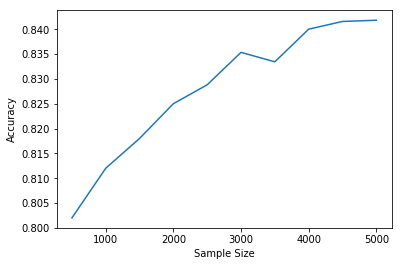